## Seq2Seq Model (with Encoder and Decoder using GRU) for translating English sentences to Hindi

If you have checked out the previous model which was made using LSTM, then this model follows the same pipeline but it will be more optimized, better trained and will be made using GRUs (gated reccurant unit), which is a more optimized version of LSTMs, made for less computation but with similar outputs

### Importing the Prerequisites

In [ ]:
import re
import nltk
import time
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

random_seed = 235
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cuda.deterministic = True

drive.mount("/content/drive")

Mounted at /content/drive


### Importing the dataset
Dataset used : [IITB English to Hindi parallel Corpus](https://www.cfilt.iitb.ac.in/iitb_parallel/)

Consists of around 1.5 Million English sentences with their Hindi translations

In [ ]:
enhi_data_path = "/content/drive/MyDrive/another start/seq2seq/hindi_english_parallel.csv"

enhi_df = pd.read_csv(enhi_data_path)
enhi_df.head(2), enhi_df.shape

(                                             hindi  \
 0  अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें   
 1                  एक्सेर्साइसर पहुंचनीयता अन्वेषक   
 
                                           english  
 0  Give your application an accessibility workout  
 1               Accerciser Accessibility Explorer  ,
 (1561841, 2))

In [ ]:
en_sents0 = enhi_df.loc[:,"english"]
en_sents0 = [str(x) for x in en_sents0]
hi_sents0 = enhi_df.loc[:,"hindi"]
hi_sents0 = [str(x) for x in hi_sents0]

In [ ]:
token_count_en = []
token_count_hi = []

for eng, hin in zip(en_sents0, hi_sents0):
  token_count_en.append(len(eng.split()))
  token_count_hi.append(len(hin.split()))

print(f"Mean length of English sentences {sum(token_count_en) / len(token_count_en)}")
print(f"Mean length of Hindi sentences {sum(token_count_hi) / len(token_count_hi)}")

Mean length of English sentences 12.709731016153373
Mean length of Hindi sentences 13.702174549137844


Filtering out some sentences because our model is implemented without attention and it might already perform pretty bad, and I don't have a GPU so training even this is a big hassle for me :)

In [ ]:
max_len = 25

en_sents = []
hi_sents = []

for eng, hin in zip(en_sents0, hi_sents0):
  if len(eng.split()) <= max_len and len(hin.split()) <= max_len:
    en_sents.append(eng)
    hi_sents.append(hin)

print(f"Filtered {len(en_sents)} sentences of length {max_len} of less")

Filtered 1284344 sentences of length 25 of less


### Aggregating and Preprocessing the data

In [ ]:
enhi_pairs0 = list({"en":en, "hi":hi} for en, hi in zip(en_sents, hi_sents))
enhi_pairs0[0]

{'en': 'Give your application an accessibility workout',
 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}

In [ ]:
enhi_pairs = []

size = 100_000

for _ in range(size):
  i = np.random.randint(0, len(enhi_pairs0))
  enhi_pairs.append(enhi_pairs0[i])

print(f"Made a test subset of {len(enhi_pairs)} pairs")

Made a test subset of 100000 pairs


#### Tokenization and Cleaning the sentences

In [ ]:
en_nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r'\$.*?\$', '', text)
    punctuation = [
        "।", ",", "?",".","\"",
        "'", ":", ";", "(", ")",
        "[", "]", "{", "}","-",
        "!", "/", "\\", "*"]
    for p in punctuation:
        text = text.replace(p, " ")
    text = " ".join(text.split())
    return text

def tokenize(sample, en_nlp, max_len, sos_token, eos_token):
  en_tokens = [token.text for token in en_nlp.tokenizer(clean_text(sample["en"]))][:max_len]
  hi_tokens = clean_text(sample["hi"]).split()[:max_len]

  en_tokens = [token.lower() for token in en_tokens]
  hi_tokens = [token.lower() for token in hi_tokens]

  en_tokens = [sos_token] + en_tokens + [eos_token]
  hi_tokens = [sos_token] + hi_tokens + [eos_token]

  return {"en":en_tokens, "hi":hi_tokens}

In [ ]:
sos_token = "<sos>"
eos_token = "<eos>"

enhi_token_pairs = []

for enhi_pair in tqdm(enhi_pairs):
  enhi_token_pairs.append(
      tokenize(
        enhi_pair,
        en_nlp,
        max_len,
        sos_token,
        eos_token,
      ))

enhi_token_pairs[0]

  0%|          | 0/100000 [00:00<?, ?it/s]

{'en': ['<sos>',
  'he',
  'was',
  'so',
  'charmed',
  'by',
  'them',
  'that',
  'he',
  'went',
  'on',
  'reciting',
  'them',
  'whether',
  'there',
  'was',
  'any',
  'occasion',
  'for',
  'doing',
  'so',
  'or',
  'not',
  '<eos>'],
 'hi': ['<sos>',
  'वह',
  'इससे',
  'इतने',
  'प्रसन्न',
  'हुए',
  'कि',
  'वह',
  'मौके',
  'बेमौके',
  'उन्हें',
  'बहुत',
  'संतोष',
  'हुआ',
  '<eos>']}

#### Creating the Language's Vocabulary

In [ ]:
def make_vocab(tokens, min_freq, special_tokens):
  en_freq, hi_freq, en_vocab, hi_vocab, en_rev, hi_rev = {},{},{},{},{},{}

  for enhi_pair in tokens:
    for token in enhi_pair["en"]:
      en_freq[token] = en_freq.get(token, 0) + 1
    for token in enhi_pair["hi"]:
      hi_freq[token] = hi_freq.get(token, 0) + 1

  en_freq = dict(sorted(en_freq.items(), key=lambda x: x[1], reverse=True))
  hi_freq = dict(sorted(hi_freq.items(), key=lambda x: x[1], reverse=True))

  for i, sptokens in enumerate(special_tokens):
    en_vocab[sptokens] = i
    hi_vocab[sptokens] = i

  i = len(special_tokens)
  for key, val in hi_freq.items():
    if val > min_freq and key not in special_tokens:
      hi_vocab[key] = i
      i += 1

  i = len(special_tokens)
  for key, val in en_freq.items():
    if val > min_freq and key not in special_tokens:
      en_vocab[key] = i
      i += 1

  for key, val in en_vocab.items():
    en_rev[val] = key
  for key, val in hi_vocab.items():
    hi_rev[val] = key

  return en_vocab, en_rev, hi_vocab, hi_rev

I have added 4 special tokens for representing :  
\<sos\> : start of sentence  
\<eos\> : end of sentence  
\<unk\> : represents unknown words  
\<pad\> : used for padding every sentence to an equal length  

In [ ]:
min_freq = 3
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab, en_rev, hi_vocab, hi_rev = make_vocab(
    tokens=enhi_token_pairs,
    min_freq=min_freq,
    special_tokens=special_tokens,
           )

In [ ]:
len(en_vocab), len(en_rev), len(hi_vocab), len(hi_rev)

(13840, 13840, 14649, 14649)

#### Converting the sentences and their tokens into their respective IDs

In [ ]:
unk_index = en_vocab["<unk>"]
pad_index = en_vocab["<pad>"]

In [ ]:
def encode(sample, en_vocab, hi_vocab, pad_index=pad_index, max_len=max_len + 2):
  en_encoded, hi_encoded = [], []
  for en_token in sample["en"]:
    en_encoded.append(en_vocab.get(en_token, 0))
  for hi_token in sample["hi"]:
    hi_encoded.append(hi_vocab.get(hi_token, 0))

  while len(en_encoded) < max_len:
    en_encoded.append(pad_index)
  while len(hi_encoded) < max_len:
    hi_encoded.append(pad_index)

  return {"en":en_encoded, "hi":hi_encoded}

In [ ]:
enhi_ids = []

for enhi_pair in tqdm(enhi_token_pairs):
  enhi_ids.append(
      encode(
        enhi_pair,
        en_vocab,
        hi_vocab
      ))

enhi_ids[0]

  0%|          | 0/100000 [00:00<?, ?it/s]

{'en': [2,
  21,
  22,
  45,
  0,
  25,
  43,
  12,
  21,
  433,
  20,
  10141,
  43,
  228,
  44,
  22,
  78,
  805,
  11,
  649,
  45,
  29,
  17,
  3,
  1,
  1,
  1],
 'hi': [2,
  29,
  216,
  1529,
  3667,
  75,
  17,
  29,
  4874,
  0,
  81,
  66,
  6057,
  86,
  3,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

#### Seperating the input, output and making a dataloader from them

In [ ]:
def get_dataloader(dataset, batch_size, shuffle = False):
  en_sents, hi_sents = [],[]
  for pair in dataset:
    en_sents.append(pair["en"])
    hi_sents.append(pair["hi"])

  en_sents = torch.tensor(en_sents, dtype=torch.long)
  hi_sents = torch.tensor(hi_sents, dtype=torch.long)

  dataset_new = torch.utils.data.TensorDataset(en_sents, hi_sents)
  dataloader = torch.utils.data.DataLoader(
      dataset = dataset_new,
      batch_size = batch_size,
      shuffle = shuffle,
  )
  print(f"Made a dataloader of size {len(dataloader)}")
  return dataloader

In [ ]:
batch_size = 128

dataloader = get_dataloader(
    dataset=enhi_ids,
    batch_size = batch_size,
    )

Made a dataloader of size 782


### Building the Encoder with GRU



In [ ]:
class Encoder(nn.Module):
  def __init__(self, en_vocab_size, embed_dim, hidden_dim, dropout):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(en_vocab_size, embed_dim)
    self.gru = nn.GRU(embed_dim, hidden_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input):
    # input shape : [batch_size, input_len]
    embed = self.dropout(self.embedding(input))
    # embedding shape : [batch_size, input_len, embed_dim]
    output, hidden = self.gru(embed)
    # output shape : [batch_size, input_len, hidden_dim * n_directions] {note : n_direcitons = 1}
    # hidden shape : [n_layers * n_directions, batch_size ,hidden_dim]
    return hidden

### Building the Decoder with GRU

In [ ]:
class Decoder(nn.Module):
  def __init__(self, hi_vocab_size, embed_dim, hidden_dim, dropout):
    super().__init__()
    self.hi_vocab_size = hi_vocab_size
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(hi_vocab_size, embed_dim)
    self.gru = nn.GRU(embed_dim + hidden_dim, hidden_dim)
    self.fc_out = nn.Linear(embed_dim + hidden_dim*2, hi_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, context):
    # input shape : [batch_size]
    # hidden shape : [n_layers * n_directions, batch_size ,hidden_dim]
    # context = [n layers * n directions, batch size, hidden dim]
    input = input.unsqueeze(0)
    # input new shape : [batch_size, 1]
    embed = self.dropout(self.embedding(input))
    # embedding shape : [batch_size, 1, embed_dim]
    embed_con = torch.cat((embed, context), dim = 2)
    # embed_con = [1, batch_size, hidden_dim * n_directions]
    output, hidden = self.gru(embed_con, hidden)
    # output shape : [batch_size, seq_len, hidden_dim * n_directions]
    # hidden shape : [n_layers * n_directions, batch_size ,hidden_dim]
    # seq_len and n_directions both will be 1
    output = torch.cat(
        (embed.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim = 1
    )
    prediction = self.fc_out(output)
    # prediction shape : [batch_size, hi_vocab_size]
    return prediction, hidden

### Building the Seq2Seq model

In [ ]:
class seq2seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    assert (
        encoder.hidden_dim == decoder.hidden_dim
    ), "Hidden dimensions of encoder and decoder are unequal"

  def forward(self, input, target, teacher_forcing_ratio):
    # input shape : [batch_size, input_len]
    # target shape : [batch_size, target_len]
    # teacher_forcing_ratio is the probability to do teacher forcing
    batch_size = target.shape[1]
    target_len = target.shape[0]
    hi_vocab_size = self.decoder.hi_vocab_size

    outputs = torch.zeros(target_len, batch_size, hi_vocab_size).to(self.device)

    context = self.encoder(input)
    hidden = context

    decoder_input = target[0, :]

    for t in range(1, target_len):
      output, hidden = self.decoder(decoder_input, hidden, context)
      outputs[t] = output
      teacher_force = random.random() < teacher_forcing_ratio
      top1 = output.argmax(1)
      next_input = target[t] if teacher_force else top1

    return outputs

### Initializing the model

In [ ]:
en_vocab_size = len(en_vocab)
hi_vocab_size = len(hi_vocab)
encoder_embed_dim = 256
decoder_embed_dim = 256
hidden_dim = 256
encoder_dropout = 0.05
decoder_dropout = 0.05
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    en_vocab_size,
    encoder_embed_dim,
    hidden_dim,
    encoder_dropout
)

decoder = Decoder(
    hi_vocab_size,
    decoder_embed_dim,
    hidden_dim,
    decoder_dropout
)

model = seq2seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.003)
criterion = nn.CrossEntropyLoss(ignore_index = pad_index)

In [ ]:
def init_weights(model):
  for name, param in model.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"The model has {count_parameters(model):,} trainable parameters")
model.apply(init_weights)

The model has 19,544,377 trainable parameters


seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(13840, 256)
    (gru): GRU(256, 256)
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(14649, 256)
    (gru): GRU(512, 256)
    (fc_out): Linear(in_features=768, out_features=14649, bias=True)
    (dropout): Dropout(p=0.05, inplace=False)
  )
)

### Loading the model (if trained)

In [ ]:
# model_path = "/content/drive/MyDrive/another start/seq2seq/enhi_lstm_seq2seq.pth"

# model.load_state_dict(torch.load(model_path))
# model.eval()

In [ ]:
epoch_plot = []

### Training the model

In [ ]:
torch.manual_seed(random_seed)

model.train()

clip = 1
epochs = 5
teacher_forcing_ratio = 0.8

epoch_list = []

for epoch in range(epochs):
  running_loss = 0
  print(f"Epoch {epoch+1}/{epochs}", end = " | ")
  start = time.time()
  for eng, hin in tqdm(dataloader):
    eng = eng.to(device) # input
    hin = hin.to(device) # target
    # eng shape : [batch_size, input_len]
    # hin shape : [batch_size, target_len]
    optimizer.zero_grad()
    output = model(eng, hin, teacher_forcing_ratio)
    # output shape : [batch_size, target_len, hi_vocab_size]
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    # output shape : [batch_size * (target_len-1), hi_vocab_size]
    hin = hin[1:].view(-1)
    # hin shape : [batch_size * (target_len - 1)]
    loss = criterion(output, hin)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    running_loss += loss.item()

  running_loss = (running_loss / len(dataloader))
  end = time.time()

  epoch_list.append(running_loss)

  print(f"Loss -> {running_loss} | time took -> {((end - start)/60):.3} minutes")
  if running_loss < 2.0:
    break

Epoch 1/5 | 

  0%|          | 0/782 [00:00<?, ?it/s]

Loss -> 4.935877471323818 | time took -> 8.28 minutes
Epoch 2/5 | 

  0%|          | 0/782 [00:00<?, ?it/s]

Loss -> 4.947423408403421 | time took -> 8.25 minutes
Epoch 3/5 | 

  0%|          | 0/782 [00:00<?, ?it/s]

Loss -> 4.97436370874 | time took -> 8.25 minutes
Epoch 4/5 | 

  0%|          | 0/782 [00:00<?, ?it/s]

Loss -> 5.003600613235513 | time took -> 8.26 minutes
Epoch 5/5 | 

  0%|          | 0/782 [00:00<?, ?it/s]

Loss -> 4.972433386861211 | time took -> 8.27 minutes


The model trained for a while but the loss does not seem to go below 5.0  
not sure why that is happening, but I guess implementing the Attention model with the current model might help.

Saving the model for keeping it safe

In [ ]:
torch.save(model.state_dict(), "seq2seq_gru.pth")
files.download("seq2seq_gru.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
epoch_plot += epoch_list

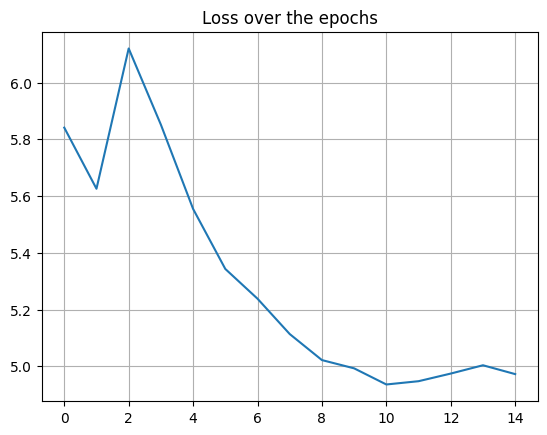

In [ ]:
plt.plot(epoch_plot)
plt.title("Loss over the epochs")
plt.grid()
plt.show()

### Evaluating our Model

The function below takes in an english sentence and the model predicts on it to convert into hindi

In [ ]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    en_vocab,
    hi_vocab,
    hi_rev,
    sos_token,
    eos_token,
    device,
    max_output_length = 25,
    temperature = 1.0,
    ):
  model.eval()
  with torch.no_grad():
    if isinstance(sentence, str):
      tokens = [token.text for token in en_nlp.tokenizer(clean_text(sentence))]
    else:
      tokens = [token for token in sentence]

    tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]

    ids = []
    for token in tokens:
      ids.append(en_vocab.get(token, 0))

    tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
    context = model.encoder(tensor)
    hidden = context

    inputs = [hi_vocab[sos_token]]

    for _ in range(max_output_length):
      inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
      output, hidden = model.decoder(inputs_tensor, hidden, context)
      logits = output / temperature

      probs = torch.softmax(logits, dim=-1)

      predicted_token = torch.multinomial(probs, num_samples=1).item()

      inputs.append(predicted_token)
      if predicted_token == hi_vocab[eos_token]:
        break

    tokens = []
    for id in inputs:
      tokens.append(hi_rev.get(id, "<unk>"))

  return " ".join(tokens[1:-1])

In [ ]:
i = np.random.randint(0, len(enhi_pairs))
sentence = enhi_pairs[i]["en"]
translation = enhi_pairs[i]["hi"]

# sentence = "the boy is playing"
# translation = ""

model_translation = translate_sentence(
    sentence = sentence,
    model = model,
    en_nlp = en_nlp,
    hi_vocab = hi_vocab,
    en_vocab = en_vocab,
    hi_rev = hi_rev,
    sos_token = sos_token,
    eos_token = eos_token,
    device = device,
    temperature=0.1,
)

print(f"{i} English sentence -> {sentence}\nHindi translation -> {translation}\nModel translation -> {model_translation}")

67873 English sentence -> fine-looking
Hindi translation -> मनोज्ञ
Model translation -> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos>


Well... as expected, the model does not work that great and gets almost no word correct which is pretty funny to think about  
well, maybe the model might work better with the attention model combined

with that, lets for a final evaluation, calculate the bleu score on a subset of 1000 sentences.

In [ ]:
test_pairs = []

for _ in range(1000):
  i = np.random.randint(0, len(enhi_pairs))
  test_pairs.append(enhi_pairs[i])

print(f"Made a test subset of {len(test_pairs)} pairs")

In [ ]:
model_translations = [
  translate_sentence(
        sentence = pairs["en"],
        model = model,
        en_nlp = en_nlp,
        hi_vocab = hi_vocab,
        en_vocab = en_vocab,
        hi_rev = hi_rev,
        sos_token = sos_token,
        eos_token = eos_token,
        device = device,
        temperature=0.9,
        )
  for pairs in tqdm(test_pairs)
  ]

In [ ]:
model_translations = [sent.split() for sent in model_translations]
actual_translations = [sent["hi"].split() for sent in test_pairs]

In [ ]:
bleu_score = corpus_bleu(
    [[ref] for ref in actual_translations],
    model_translations
)
print(f"BLEU score : {bleu_score}")

In [ ]:
# BLEU score 10^-100